In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Train PCA shape: (966, 150)
Test PCA shape: (322, 150)


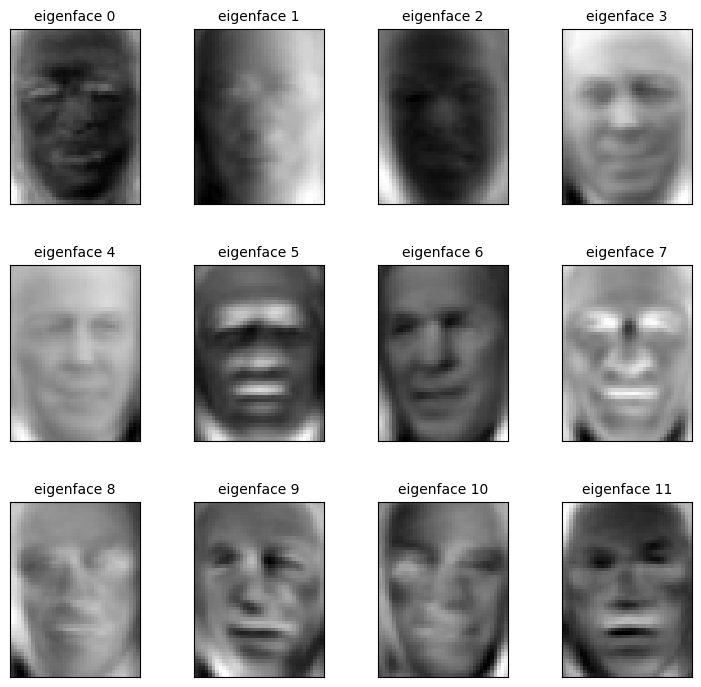

In [2]:

# -----------------------------
# 1. Load LFW People Dataset
# -----------------------------
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Introspect image array to find shape
n_samples, h, w = lfw_people.images.shape

# Use data matrix (flattened images) for ML
X = lfw_people.data
n_features = X.shape[1]

# Labels (target = person ID)
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print(f"n_samples: {n_samples}")
print(f"n_features: {n_features}")
print(f"n_classes: {n_classes}")

# -----------------------------
# 2. Split into Train/Test
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# -----------------------------
# 3. PCA (Eigenfaces)
# -----------------------------
n_components = 150  # Number of eigenfaces to keep

# Center data (subtract training mean)
mean = np.mean(X_train, axis=0)
X_train_centered = X_train - mean
X_test_centered = X_test - mean

# Perform SVD: X = U * S * V
U, S, Vt = np.linalg.svd(X_train_centered, full_matrices=False)

# Principal components (top eigenfaces)
components = Vt[:n_components]

# Reshape components into eigenfaces
eigenfaces = components.reshape((n_components, h, w))

# Project data into PCA subspace (face space)
X_train_pca = np.dot(X_train_centered, components.T)
X_test_pca = np.dot(X_test_centered, components.T)

print("Train PCA shape:", X_train_pca.shape)
print("Test PCA shape:", X_test_pca.shape)

# -----------------------------
# 4. Plot Eigenfaces
# -----------------------------
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of images."""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=10)
        plt.xticks(())
        plt.yticks(())

# Titles for the eigenfaces
eigenface_titles = [f"eigenface {i}" for i in range(eigenfaces.shape[0])]

# Show the first 12 eigenfaces
plot_gallery(eigenfaces, eigenface_titles, h, w, n_row=3, n_col=4)
plt.show()


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# -----------------------------
# 1. Load and preprocess data
# -----------------------------
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

X = lfw_people.images       # shape (n_samples, h, w)
Y = lfw_people.target       # integer labels

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# Add channel dimension: (N, 1, H, W)
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Build dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# -----------------------------
# 2. Define CNN model
# -----------------------------
class FaceCNN(nn.Module):
    def __init__(self, num_classes, input_shape):
        super(FaceCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()

        # Infer flattened size dynamically
        with torch.no_grad():
            example = torch.zeros(1, 1, input_shape[0], input_shape[1])
            x = self.pool(torch.relu(self.conv1(example)))
            x = self.pool(torch.relu(self.conv2(x)))
            flat_size = x.view(-1).shape[0]

        self.fc1 = nn.Linear(flat_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# -----------------------------
# 3. Setup device (GPU if available)
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

num_classes = len(np.unique(Y))
h, w = X_train.shape[2], X_train.shape[3]
model = FaceCNN(num_classes, (h, w)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -----------------------------
# 4. Training loop
# -----------------------------
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {running_loss:.4f} | Train Acc: {acc:.4f}")

# -----------------------------
# 5. Evaluation
# -----------------------------
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct/total:.4f}")


Using device: cuda
Epoch [1/10] | Loss: 53.0025 | Train Acc: 0.3778
Epoch [2/10] | Loss: 52.2441 | Train Acc: 0.4017
Epoch [3/10] | Loss: 49.5417 | Train Acc: 0.4327
Epoch [4/10] | Loss: 41.9996 | Train Acc: 0.5031
Epoch [5/10] | Loss: 35.4242 | Train Acc: 0.5911
Epoch [6/10] | Loss: 27.3912 | Train Acc: 0.6967
Epoch [7/10] | Loss: 20.7528 | Train Acc: 0.7795
Epoch [8/10] | Loss: 16.7886 | Train Acc: 0.8188
Epoch [9/10] | Loss: 13.5329 | Train Acc: 0.8675
Epoch [10/10] | Loss: 11.7067 | Train Acc: 0.8747
Test Accuracy: 0.8137
